In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape, Dense, Conv2D, GlobalAveragePooling2D
import keras.optimizers as optimizers
from keras.callbacks import ModelCheckpoint
from keras.applications.vgg19 import VGG19, preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import numpy as np

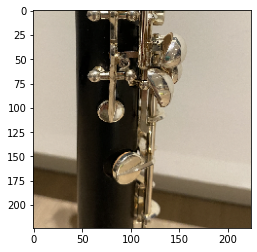

In [3]:
img_path = "drive/MyDrive/oboe.png"

img = image.load_img(img_path, target_size=(224, 224, 3))

image = image.img_to_array(img)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

image = preprocess_input(image)
plt.imshow(img)


plt.show()

In [4]:
vgg = VGG19(weights = 'imagenet')

574726144/574710816 [==============================] - 6s 0us/step


In [5]:
prediction = vgg.predict(image)

49152/35363 [=========================================] - 0s 0us/step


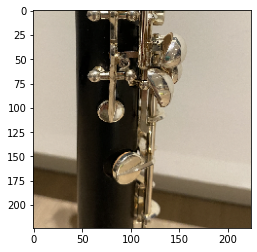



oboe (84.96%)


In [6]:
label = decode_predictions(prediction)
# retrieve the most likely result, e.g. highest probability
label = label[0][0]
label2 = label[0][1]
label3 = label[0][1]
# print the classification

plt.imshow(img)
plt.show()
print('\n')

print('%s (%.2f%%)' % (label[1], label[2]*100))


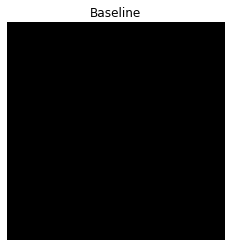

In [7]:
#Implementing our Baseline
baseline = tf.zeros(shape=(224,224,3))

#Displaying it with matplotlib
plt.imshow(baseline)
plt.title("Baseline")
plt.axis('off')
plt.show()

In [8]:
from tensorflow import io

#Convert image to a tensor - 3 RGB Channels - resized to 224x224
image = tf.io.read_file("drive/MyDrive/oboe.png")
image = tf.io.decode_jpeg(image, channels=3)
image = tf.image.convert_image_dtype(image, tf.float32)
image = tf.image.resize_with_pad(image, target_height=224, target_width=224)


#Generates 50 intervals for the interpolation of images
alpha = tf.linspace(start=0.0, stop=1.0, num= 50) 

In [9]:
def interpolation(baseline, image, alpha):
  #Interpolates images by computing the difference between its pixel values 
  #and the baseline (all zeroes)
  #From there, construct a new tensor containing the baseline and interpolated
  #images, which are the picture values multiplied by the linear relationship.
  alphaTensor = alpha[:, tf.newaxis, tf.newaxis, tf.newaxis]
  
  baselineTensor = tf.expand_dims(baseline, axis=0)
  inputTensor = tf.expand_dims(image, axis=0)
  diff = inputTensor - baselineTensor
  images = baselineTensor +  alphaTensor * diff
  return images

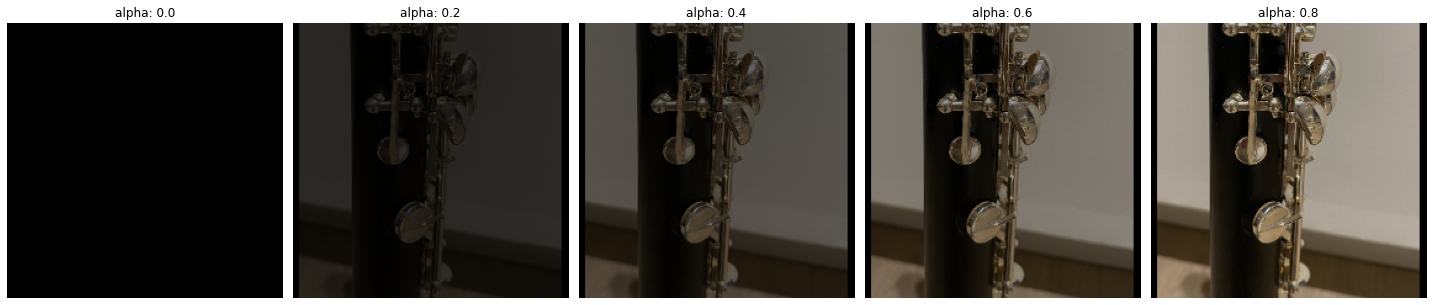

In [10]:
interpolatedImages = interpolation(baseline=baseline,image=image,alpha=alpha)

fig = plt.figure(figsize=(20, 20))
i = 0
for alphas, image in zip(alpha[0::10], interpolatedImages[0::10]):
  i += 1
  plt.subplot(1, len(alpha[0::10]), i)
  plt.title(f'alpha: {alphas:.1f}')
  plt.imshow(image)
  plt.axis('off')
plt.tight_layout();

In [11]:
def gradient(images, targetClassindex):
  #Computes gradient of probabilities with respect to images
  with tf.GradientTape() as gradRecord:
    gradRecord.watch(images)
    logits = vgg(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, targetClassindex]
    
  return gradRecord.gradient(probs, images)


computedGradients = gradient(interpolatedImages,684) #ImageNet Index for Oboe is 683, so add 1 to receive the value to stop at.

In [12]:
def integralEstimates(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

integ = integralEstimates(gradients=computedGradients)

In [22]:
def plotAttributions(baseline,attributions,
                          image,
                          cmap=None,
                          overlay_alpha=0.4):


  #Sum of the abs value of the attriutions determining feature importance
  mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)


  fig, ax = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  #Original image
  ax[0, 1].set_title('Original')
  ax[0, 1].imshow(image)
  ax[0, 1].axis('off')

  #Baseline image
  ax[0, 0].set_title('Baseline')
  ax[0, 0].imshow(baseline)
  ax[0, 0].axis('off')

  #Just the feature attributions
  ax[1, 0].set_title('Attribution mask')
  ax[1, 0].imshow(mask, cmap=cmap)
  ax[1, 0].axis('off')

  #Attributaions overlayed over the image - overlay_alpha is interpolation used
  ax[1, 1].set_title('Overlay')
  ax[1, 1].imshow(mask, cmap=cmap)
  ax[1, 1].imshow(image, alpha=overlay_alpha)
  ax[1, 1].axis('off')

  plt.tight_layout()
  return fig

Figure(576x576)


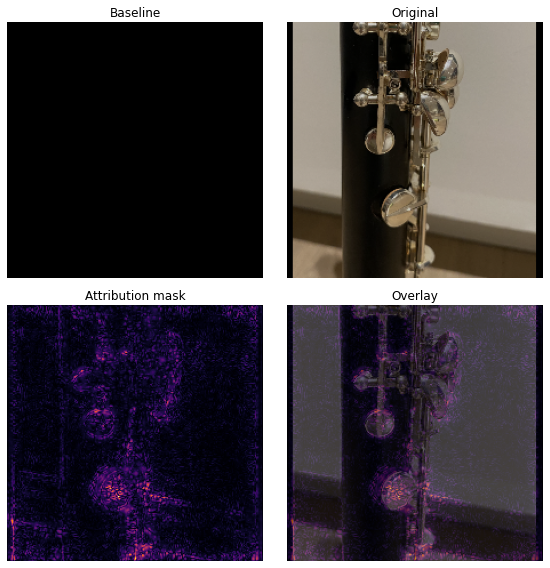

In [23]:
print(plotAttributions(baseline,integ,image,                
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4))